#1. Configurando Ambiente

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio

In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


#2. Obtención de datos

#2.1. Precios Históricos de Bitcoin

Se obtendra la base historica del bitcoin en un periodo de 7 días

In [9]:
def importar_base_bitcoin():
  global df_bitcoin
  df_bitcoin = yf.Ticker("BTC-USD").history(period='7d', interval='5m')


In [10]:
#Base Historica de precios del Bitcoin
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-16 00:00:00+00:00,27162.628906,27172.263672,27150.240234,27172.263672,0,0.0,0.0
2023-10-16 00:05:00+00:00,27170.353516,27193.248047,27170.353516,27193.248047,25181696,0.0,0.0
2023-10-16 00:10:00+00:00,27193.240234,27198.468750,27175.326172,27175.326172,28948480,0.0,0.0
2023-10-16 00:15:00+00:00,27169.886719,27170.625000,27148.345703,27148.345703,27666944,0.0,0.0
2023-10-16 00:20:00+00:00,27147.185547,27160.308594,27147.185547,27160.308594,9837568,0.0,0.0


#2.2. Indicadores de Tendencia y calculo del RSI

**- Los Indicadores de Tendencia.-** Son herramientas utilizadas en el análisis técnico proporcionan una representación más clara de si el mercado se encuentra en una tendencia alcista (subiendo), una tendencia bajista (bajando) o si no muestra una tendencia clara y se encuentra en rango.

**- El RSI.-** Se encuentra en una escala de 0 a 100 y se utiliza para determinar si un activo está en condiciones de sobrecompra (RSI alto) o sobrevendido (RSI bajo).
Un RSI por encima de 70 generalmente se considera una señal de que el activo está sobrecomprado, lo que podría indicar una posible reversión a la baja en los precios.
Un RSI por debajo de 30 generalmente se considera una señal de que el activo está sobrevendido, lo que podría indicar una posible reversión al alza en los precios.

In [11]:
def extraer_tendencias():
  global precio_actual,tendencia
  headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
  url="https://coinmarketcap.com/"
  respuesta=requests.get(url,headers=headers)
  soup=BeautifulSoup(respuesta.content,'html.parser')
  #Filtro para el valor del Precio del Bitcoin
  precios=soup.findAll('div',{'class':['sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY fall']})
  precio_actual=float(precios[0].get_text().replace('$','').replace(',',''))
  #Filtro para la tendencia
  span_element = soup.findAll('span', {'class': ['sc-d55c02b-0 iwhBxy','sc-d55c02b-0 gUnzUB']})[0]
  if 'sc-d55c02b-0 iwhBxy' in ' '.join(span_element['class']):
      tendencia = 'Alta'
  else:
      tendencia = 'Baja'


In [12]:
extraer_tendencias()
print('Bitcoin precio: ',precio_actual)
print('Tendencia: ',tendencia)

Bitcoin precio:  29839.03
Tendencia:  Baja


In [13]:
def calcular_rsi(data, period=7):
    delta = data['Close'].diff(1)
    ganancia = delta.where(delta > 0, 0)
    perdida = -delta.where(delta < 0, 0)

    media_gan = ganancia.rolling(window=period).mean()
    media_per = perdida.rolling(window=period).mean()

    rs = media_gan / media_per
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

# 3. Limpieza de Datos

En la limpieza de datos se eliminaron los nulos luego para eliminar valores atípicos o más conocidos como los outlier para calcular la media del bitcoin en la columna del precio de cierre ['Close']

In [14]:
df_bitcoin_limpio=df_bitcoin.copy()
df_bitcoin_limpio.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-16 00:00:00+00:00,27162.628906,27172.263672,27150.240234,27172.263672,0,0.0,0.0
2023-10-16 00:05:00+00:00,27170.353516,27193.248047,27170.353516,27193.248047,25181696,0.0,0.0
2023-10-16 00:10:00+00:00,27193.240234,27198.468750,27175.326172,27175.326172,28948480,0.0,0.0
2023-10-16 00:15:00+00:00,27169.886719,27170.625000,27148.345703,27148.345703,27666944,0.0,0.0
2023-10-16 00:20:00+00:00,27147.185547,27160.308594,27147.185547,27160.308594,9837568,0.0,0.0


In [23]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  #Verificar si en la columna Close hay valores nulos
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio['Close'].isnull()]
  #eliminamos los datos de la columna Volume que no sean mayor que 0
  df_bitcoin_limpio=df_bitcoin_limpio[df_bitcoin_limpio['Volume']>0]
  #Eliminamos Outliers
  valor=df_bitcoin_limpio['Close']
  q1 = valor.quantile(0.25)
  q3 = valor.quantile(0.75)
  seleccion=((df_bitcoin_limpio['Close']>=q1)&(df_bitcoin_limpio['Close']<=q3))
  df_bitcoin_limpio=df_bitcoin_limpio[seleccion]
  media_bitcoin=df_bitcoin_limpio['Close'].mean()
  media_bitcoin

La media es 28594.46963443396


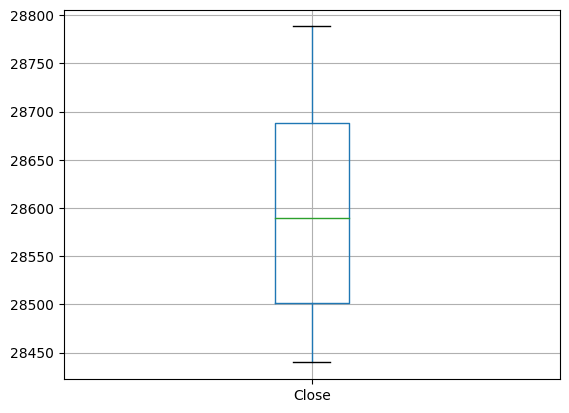

In [24]:
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close'])
print(f'La media es {media_bitcoin}')

#4. Tomar Decisiones

In [25]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  df_bitcoin = calcular_rsi(df_bitcoin, period=7)
  if precio_actual>=media_bitcoin and tendencia =='Baja'and df_bitcoin['RSI'].iloc[-1] > 70:
    algoritmo_decision='Vender'
  elif precio_actual<media_bitcoin and tendencia=='Alta' and df_bitcoin['RSI'].iloc[-1] < 30:
    algoritmo_decision='Comprar'
  else:
    algoritmo_decision='Esperar'

In [26]:
#mostramos la desicion del algoritmo
tomar_decisiones()
print('Precio Promedio del Bitcoin: ',media_bitcoin)
print('Precio Actual del Bitcoin: ',precio_actual)
print('Tendencia: ',tendencia)
print('Desicion del Algoritmo: ',algoritmo_decision)

Precio Promedio del Bitcoin:  28594.46963443396
Precio Actual del Bitcoin:  29839.03
Tendencia:  Baja
Desicion del Algoritmo:  Esperar


#5. Visualización

In [27]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  #Adicionamos una nueva columna en el dataFrame
  df_bitcoin['Promedio'] = media_bitcoin
  #Tamaño del Gráfico
  plt.figure(figsize=(16,5))
  #Titulo al Gráfico
  plt.title('Bitcoin')
  #Dibujar linea para los datos de la columna Close
  df_bitcoin['Close'].plot(label='Precio Actual')
  #Dibujar linea para los datos de la columna Promedio
  df_bitcoin['Promedio'].plot(label='Promedio')
  plt.xlabel('Fecha')
  plt.ylabel('Precio')
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),xytext=(-130, 80), textcoords='offset points',
  arrowprops=dict(arrowstyle='->'),fontsize=14)
  # Mostrar gráfico
  plt.show()

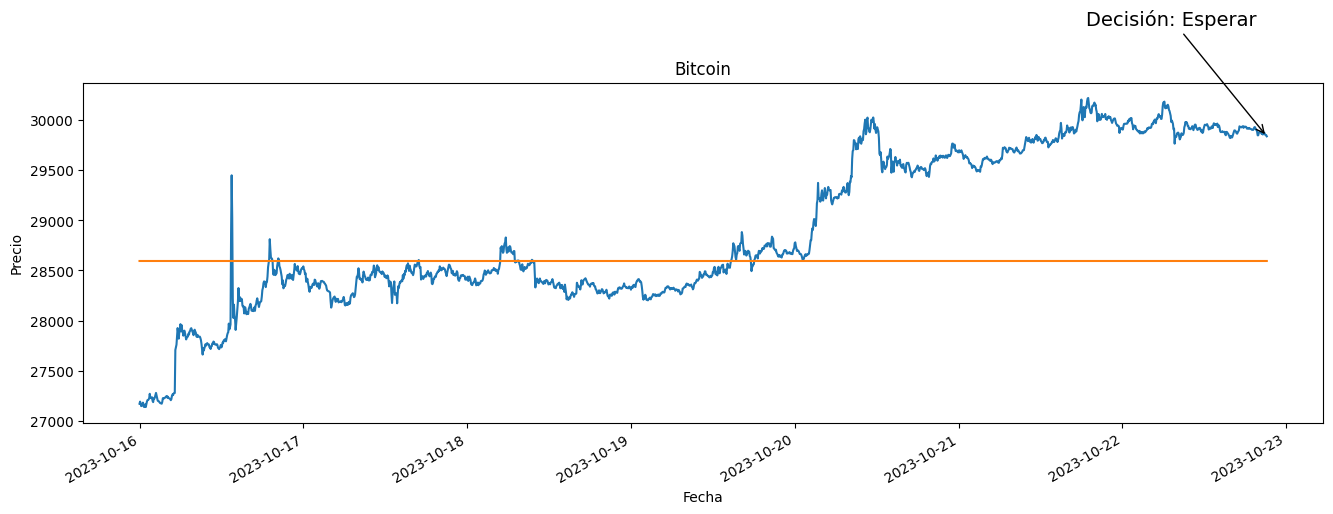

In [28]:
visualizacion()

#Automatizar

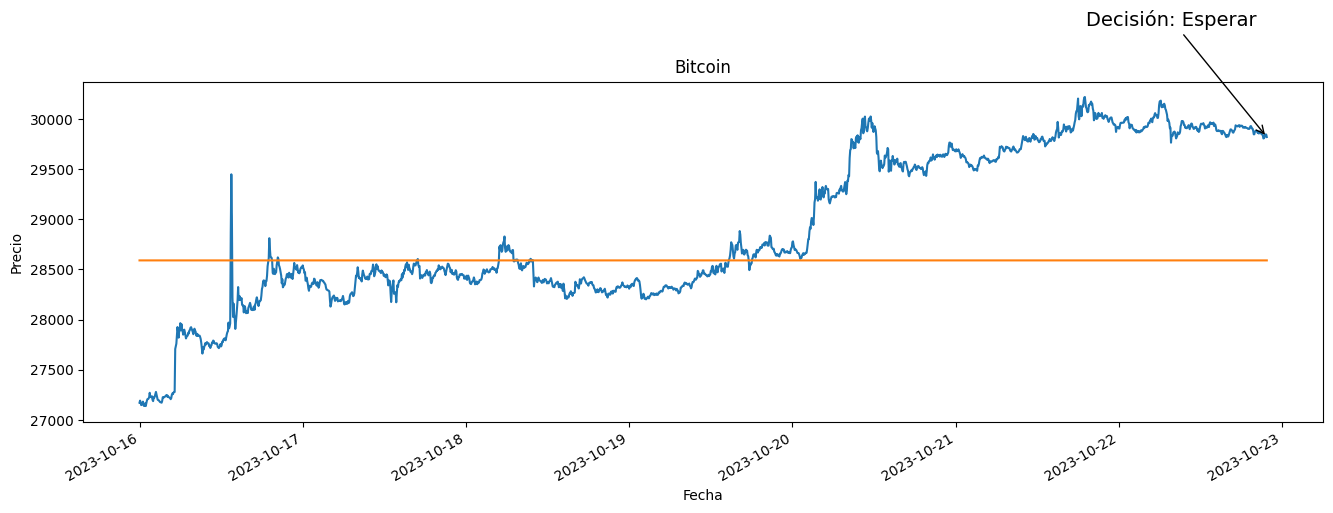

In [ ]:
from IPython.display import clear_output
import time

while True:
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)